In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark

Hit:1 https://packages.cloud.google.com/apt gcsfuse-focal InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Hit:5 https://packages.cloud.google.com/apt cloud-sdk InRelease                
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Hit:7 https://packages.cloud.google.com/apt google-fast-socket InRelease       
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1190 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1514 kB]m
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1225 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packag

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/05 03:17:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [3]:
train_csv = "/kaggle/input/eece5645-project/ISIC_2019_Training_GroundTruth.csv"
image_folder = "/kaggle/input/eece5645-project/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

In [4]:
rdd = spark.sparkContext.textFile(train_csv).map(lambda x: x.split(","))
rdd.take(5)

[['image', 'MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'],
 ['ISIC_0000000',
  '0.0',
  '1.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0'],
 ['ISIC_0000001',
  '0.0',
  '1.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0'],
 ['ISIC_0000002',
  '1.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0'],
 ['ISIC_0000003',
  '0.0',
  '1.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0']]

In [5]:
classes = rdd.map(lambda x:x[1:-1]).first()
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
class_to_idx

{'MEL': 0, 'NV': 1, 'BCC': 2, 'AK': 3, 'BKL': 4, 'DF': 5, 'VASC': 6, 'SCC': 7}

In [6]:
header = rdd.first()
rdd = rdd.filter(lambda row: row!=header)
labels = rdd.map(lambda row: [float(num) for num in row[1:-1]])
len(labels.take(1)[0])

8

In [7]:
rdd = rdd.map(lambda x: (os.path.join(image_folder, f"{x[0]}.jpg" ) ,[float(num) for num in x[1:-1]] ))
rdd.take(5)

[('/kaggle/input/eece5645-project/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000000.jpg',
  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('/kaggle/input/eece5645-project/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000001.jpg',
  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('/kaggle/input/eece5645-project/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000002.jpg',
  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('/kaggle/input/eece5645-project/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000003.jpg',
  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('/kaggle/input/eece5645-project/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000004.jpg',
  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])]

In [8]:
image_paths = rdd.map(lambda x:x[0])
image_paths.count()

25331

In [9]:
class_counts = labels.map(lambda x: x.index(max(x))).countByValue()
class_counts

defaultdict(int,
            {1: 12875,
             0: 4522,
             4: 2624,
             5: 239,
             7: 628,
             2: 3323,
             6: 253,
             3: 867})

In [10]:
classes

['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


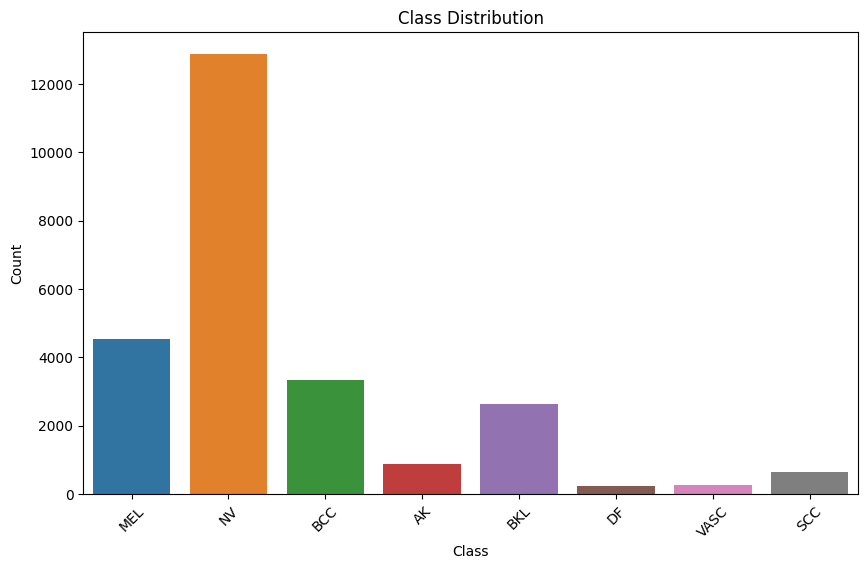

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=[class_counts[i] for i in range(len(classes))])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Split data in PySpark
train_data_rdd, test_data_rdd = rdd.randomSplit([0.8, 0.2], seed=42)

# Convert back to separate RDDs if needed
train_images = train_data_rdd.map(lambda x: x[0]).repartition(100).collect()
train_labels = train_data_rdd.map(lambda x: x[1]).repartition(100).collect()
test_images = test_data_rdd.map(lambda x: x[0]).repartition(100).collect()
test_labels = test_data_rdd.map(lambda x: x[1]).repartition(100).collect()

In [13]:
# Preprocessing functions
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [300, 300])  # Resize without 'nearest' mode
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def load_and_preprocess_from_path_labels(path, label):
    return load_and_preprocess_image(path), label

In [14]:
import tensorflow as tf
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE)\
                   .map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)\
                   .shuffle(2048).batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
# Define learning rate schedule
LR_START = 0.00001
LR_MAX = 0.00005
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = 0.8
EPOCHS = 15

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Define the basic CNN architecture
class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super(BasicCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),  # Adjust this based on input image size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [17]:
num_classes = labels.count()
num_classes

25331

In [18]:
model = BasicCNN(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define optimizer, criterion, and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()  # For multilabel classification
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
import tensorflow as tf

# Training loop
def train_model(model, train_ds, test_ds, epochs, optimizer, criterion):
    """
    Train and evaluate the model.
    Args:
        model: TensorFlow model.
        train_ds: Training dataset.
        test_ds: Validation dataset.
        epochs: Number of epochs.
        optimizer: Optimizer for training.
        criterion: Loss function.
    """
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss = tf.keras.metrics.Mean()
        train_accuracy = tf.keras.metrics.CategoricalAccuracy()
        valid_loss = tf.keras.metrics.Mean()
        valid_accuracy = tf.keras.metrics.CategoricalAccuracy()

        # Training phase
        for images, labels in train_ds:
            with tf.GradientTape() as tape:
                outputs = model(images, training=True)
                loss = criterion(labels, outputs)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            train_loss.update_state(loss)
            train_accuracy.update_state(labels, outputs)

        # Validation phase
        for images, labels in test_ds:
            outputs = model(images, training=False)
            loss = criterion(labels, outputs)

            valid_loss.update_state(loss)
            valid_accuracy.update_state(labels, outputs)

        # Logging
        print(f"Train Loss: {train_loss.result():.2f}, Train Accuracy: {train_accuracy.result():.2f}")
        print(f"Valid Loss: {valid_loss.result():.2f}, Valid Accuracy: {valid_accuracy.result():.2f}")

In [20]:
# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')  # Assuming 8 classes
])

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
criterion = tf.keras.losses.CategoricalCrossentropy()

import time
start_time = time.time()
# Train the model
train_model(model, train_ds, test_ds, epochs=20, optimizer=optimizer, criterion=criterion)
end_time = time.time()
time_diff = start_time - end_time
time_diff

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
Train Loss: 2.20, Train Accuracy: 0.52
Valid Loss: 1.29, Valid Accuracy: 0.54
Epoch 2/20
Train Loss: 1.20, Train Accuracy: 0.57
Valid Loss: 1.22, Valid Accuracy: 0.55
Epoch 3/20
Train Loss: 1.13, Train Accuracy: 0.59
Valid Loss: 1.17, Valid Accuracy: 0.57
Epoch 4/20
Train Loss: 1.06, Train Accuracy: 0.62
Valid Loss: 1.16, Valid Accuracy: 0.57
Epoch 5/20
Train Loss: 1.00, Train Accuracy: 0.64
Valid Loss: 1.23, Valid Accuracy: 0.57
Epoch 6/20
Train Loss: 0.92, Train Accuracy: 0.67
Valid Loss: 1.22, Valid Accuracy: 0.59
Epoch 7/20
Train Loss: 0.84, Train Accuracy: 0.71
Valid Loss: 1.26, Valid Accuracy: 0.58
Epoch 8/20
Train Loss: 0.77, Train Accuracy: 0.73
Valid Loss: 1.27, Valid Accuracy: 0.58
Epoch 9/20
Train Loss: 0.68, Train Accuracy: 0.77
Valid Loss: 1.43, Valid Accuracy: 0.58
Epoch 10/20
Train Loss: 0.66, Train Accuracy: 0.78
Valid Loss: 1.57, Valid Accuracy: 0.56
Epoch 11/20
Train Loss: 0.55, Train Accuracy: 0.81
Valid Loss: 1.49, Valid Accuracy: 0.56
Epoch 12/20
Train L

-1944.272206068039

In [21]:
# Evaluate model performance
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(model.predict(test_ds), axis=1)

I0000 00:00:1733370622.805110     972 service.cc:145] XLA service 0x78e2c4006e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733370622.805159     972 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/159 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step

I0000 00:00:1733370624.495170     972 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step


In [22]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5522417539008493
Precision: 0.34104706998536605
Recall: 0.2736696060477836
Confusion Matrix:
 [[ 243  519   73   28   41    0    1   18]
 [ 158 2162   77   27   93    4    1   24]
 [  59  235  242   58   44    4    1   32]
 [  15   50   39   34   15    1    1    6]
 [  67  279   55   35   93    2    1   14]
 [   3   21   10    4    7    0    1    2]
 [   2   22    3    1    1    3   11    2]
 [  17   38   28   15    8    1    1   11]]


In [23]:
# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history)

NameError: name 'history' is not defined